# Author: Tobias

In [1]:
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import json
import os
import re
import pprint
import tensorflow as tf

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
load_dotenv(find_dotenv())

%load_ext autoreload
%autoreload 2
os.getcwd()

'/srv/idp-radio-1'

In [2]:
# Run this before loading other dependencies, otherwise they might occupy memory on gpu 0 by default and it will stay that way

# Specify which GPU(s) to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Or 2, 3, etc. other than 0

config = tf.compat.v1.ConfigProto( allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 1.0
tf.compat.v1.Session(config=config)


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:03:00.0, compute capability: 7.5



In [3]:
from src.architectures.benchmarks.benchmark_definitions import Chexpert_Benchmark, Chestxray14_Benchmark, simple_architecture_experiment, generate_benchmarks, METRICS, CHEXPERT_COLUMNS, CHESTXRAY14_COLUMNS


In [4]:
reduced_columns = ['Enlarged Cardiomediastinum',
                    'Cardiomegaly',
                    'Lung Opacity',
                    'Lung Lesion',
                    'Edema',
                    'Consolidation',
                    'Pneumonia',
                    'Atelectasis',
                    'Pneumothorax',
                    'Pleural Effusion',
                    'Pleural Other',
                    'Fracture']

uzeros = ['Cardiomegaly',
        'Enlarged Cardiomediastinum',
        'Lung Opacity',
        'Lung Lesion',
        'Consolidation',
        'Pneumothorax',
        'Pleural Effusion']

uones = ['Edema',
        'Atelectasis',
        'Fracture',
        'Pleural Other',
        'Pneumonia',]

upsample_factors = {
    "Enlarged Cardiomediastinum": 1,
    "Lung Lesion":1,
    #"Pneumothorax":1,
    #"Pneumonia":1,
    "Pleural Other":2,
    "Fracture":2,
}
transformations_0 = {"hist_equalization":{}}
transformations_1 = {"hist_equalization":{}, "gaussian_blur":{"kernal_size":3}}
transformations_2 = {"unsharp_mask":{"radius":2, "amount":1}}
transformations_3 = {"windowing"}
len(reduced_columns)


columns_5 =  ['Cardiomegaly',
                'Edema',
                'Consolidation',
                'Atelectasis',
                'Pleural Effusion']
uzeros_5 = ['Cardiomegaly',
        'Consolidation',
        'Pleural Effusion']

uones_5 = ['Edema',
        'Atelectasis']

upsample_factors_5 = {
    "Consolidation":2,
    "Cardiomegaly":1
}

In [32]:
chexpert_benchmarks, _ = generate_benchmarks(path = Path(os.environ.get("CHEXPERT_DATASET_DIRECTORY")),
                                                     name_suffix="",
                                                     classes=reduced_columns,
                                                     test_labels = "test.csv",
                                                     split_valid_size = 0.05,
                                                     u_enc = "uzero",
                                                     #u_enc = [uzeros_5, uones_5],
                                                     #train_labels = "nofinding_train.csv",
                                                     #nan_replacement = -1,
                                                     batch_sizes = {"b": 16},
                                                     epoch_sizes = {"e": 1},
                                                     shuffle=False,
                                                     dim=(256, 256),
                                                     crop = {"C0": False},
                                                     split_seed = 65748123,
                                                     augmentation=None,
                                                     #transformations = transformations_2,
                                                     #upsample_factors = upsample_factors
                                            )

Initialzed custom_binary_crossentropy with epsilon 1e-05
Chestxray_BCE_E1_B16_C0_N12 could not be created
Chestxray_WBCE_E1_B16_C0_N12 could not be created
Chestxray_CWBCE_E1_B16_C0_N12 could not be created


In [33]:
list(chexpert_benchmarks.keys())[0]

'BCE_E1_B16_C0_N12'

In [34]:
benchmark = chexpert_benchmarks[list(chexpert_benchmarks.keys())[0]]

In [35]:
benchmark_dict = benchmark.as_dict()
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(benchmark_dict)

{   'augmentation': None,
    'batch_size': 16,
    'benchmark_name': 'Chexpert_BCE_E1_B16_C0_N12',
    'class_weights': [   0.9335566163063049,
                         0.37453174591064453,
                         0.09578815847635269,
                         1.1123366355895996,
                         0.19350844621658325,
                         0.685200035572052,
                         1.6749200820922852,
                         0.3026556074619293,
                         0.5163179039955139,
                         0.11731740087270737,
                         2.8737308979034424,
                         1.120137095451355],
    'crop': False,
    'dataset_folder': 'data/chexpert/full',
    'dataset_name': 'chexpert_full',
    'dim': (256, 256),
    'drop_last': False,
    'epochs': 1,
    'label_columns': [   'Enlarged Cardiomediastinum',
                         'Cardiomegaly',
                         'Lung Opacity',
                         'Lung Lesion',
                

In [12]:
benchmark.label_columns

['Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture']

In [13]:
train_labels = benchmark.traingen.get_labels_nonan()
valid_labels = benchmark.valgen.get_labels_nonan()
test_labels = benchmark.testgen.get_labels_nonan()

print("Number train samples:", len(train_labels))
print("Number valid samples:", len(valid_labels))
print("Number test samples:", len(test_labels))

Number train samples: 211864
Number valid samples: 11550
Number test samples: 234


In [17]:
def get_distribution(labels):
    labels_df = pd.DataFrame(labels, columns=benchmark.label_columns)


    d = {'Pathology': [], 'Positive': [], 'Positive %': [], 'Negative': [], 'Negative %': [],}
    for label in labels_df.columns:
        values = labels_df.groupby(label)
        d['Pathology'].append(label)

        positive = values.size()[1.0] if 1.0 in values.size() else 0
        positive_percent = positive / labels_df.shape[0] * 100
        d['Positive'].append(positive)
        d['Positive %'].append(round(positive_percent, 2))

        negative = values.size()[-0.0] if -0.0 in values.size() else 0
        negative_percent = negative / labels_df.shape[0] * 100
        d['Negative'].append(negative)
        d['Negative %'].append(round(negative_percent, 2))
    
    df = pd.DataFrame(d)
    df = df.set_index('Pathology')

    return df

<AxesSubplot:title={'center':'Test set'}, xlabel='Pathology'>

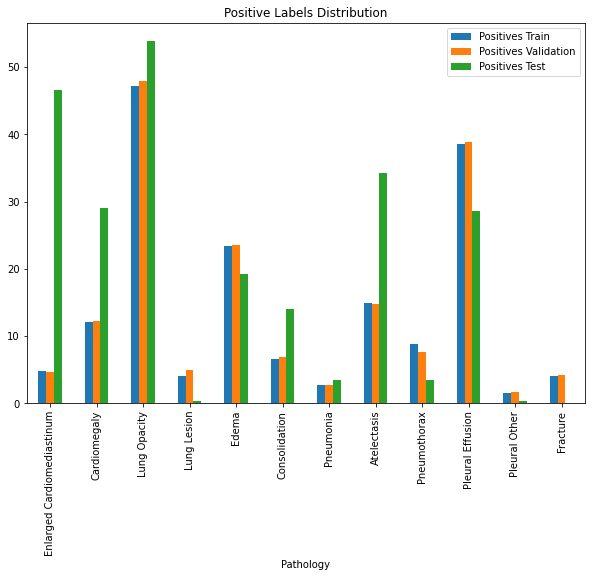

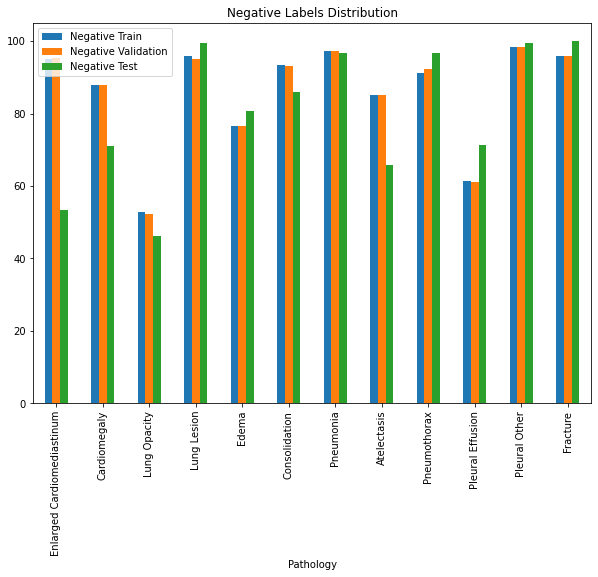

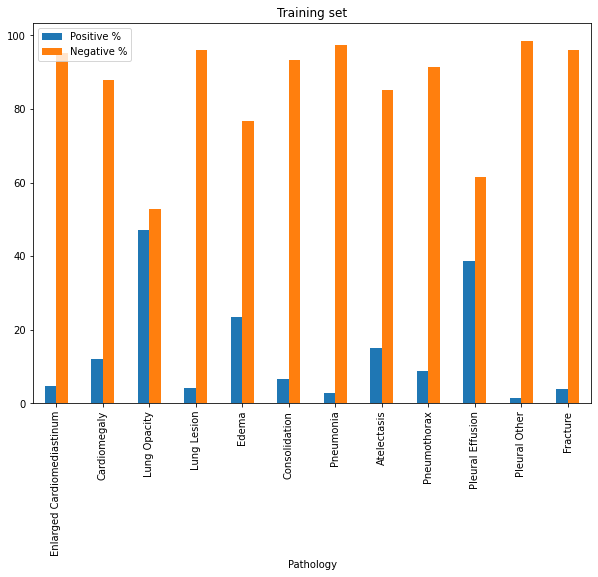

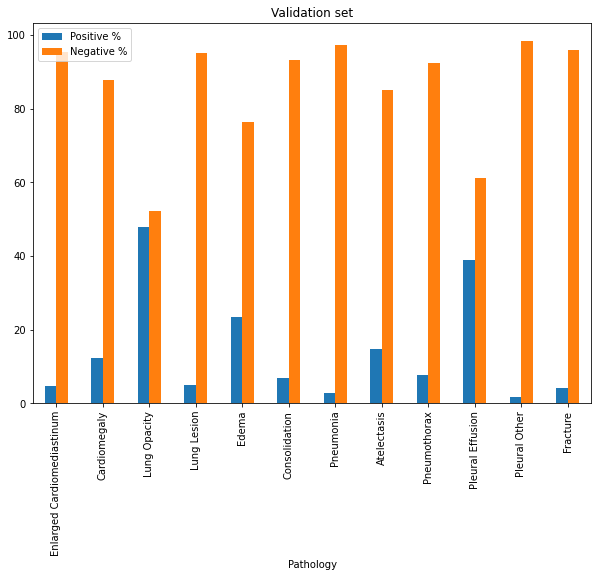

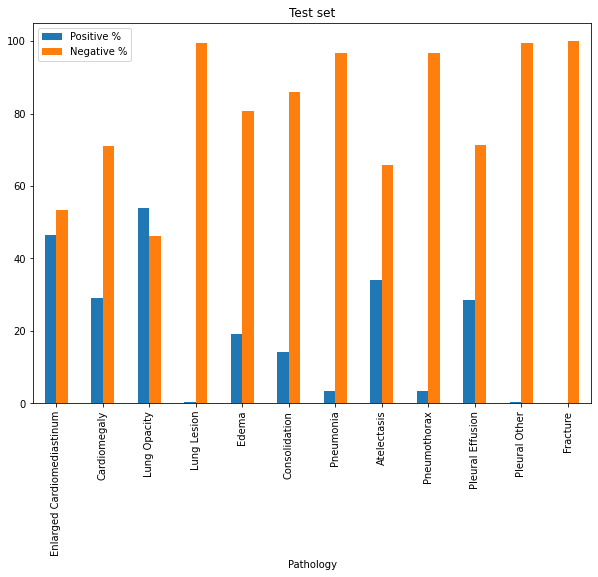

In [18]:
train = get_distribution(train_labels)
val = get_distribution(valid_labels)
test = get_distribution(test_labels)

positives = train[['Positive %']].merge(val[['Positive %']], left_index=True, right_index=True).merge(test[['Positive %']], left_index=True,  right_index=True).rename(columns={"Positive %_x": "Positives Train", "Positive %_y": "Positives Validation", "Positive %": "Positives Test", })
positives.copy().plot(kind='bar', figsize=(10,7), title="Positive Labels Distribution")

negatives = train[['Negative %']].merge(val[['Negative %']], left_index=True, right_index=True).merge(test[['Negative %']], left_index=True,  right_index=True).rename(columns={"Negative %_x": "Negative Train", "Negative %_y": "Negative Validation", "Negative %": "Negative Test", })
negatives.copy().plot(kind='bar', figsize=(10,7), title="Negative Labels Distribution")

train[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Training set")
val[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Validation set")
test[['Positive %', 'Negative %']].copy().plot(kind='bar', figsize=(10,7), title="Test set")

In [34]:
get_distribution(train_labels)

Positive  Positive %  Negative  Negative %
Pathology                                                   
Cardiomegaly         56590       21.11    211543       78.89
Edema                83585       31.17    184548       68.83
Consolidation        46020       17.16    222113       82.84
Atelectasis          80338       29.96    187795       70.04
Pleural Effusion    108466       40.45    159667       59.55

In [19]:
get_distribution(valid_labels)

Positive  Positive %  Negative  Negative %
Pathology                                                   
Cardiomegaly          1411       12.22     10139       87.78
Edema                 3377       29.24      8173       70.76
Consolidation          796        6.89     10754       93.11
Atelectasis           3475       30.09      8075       69.91
Pleural Effusion      4495       38.92      7055       61.08

In [19]:
get_distribution(test_labels)

Positive  Positive %  Negative  Negative %
Pathology                                                             
Enlarged Cardiomediastinum       109       46.58       125       53.42
Cardiomegaly                      68       29.06       166       70.94
Lung Opacity                     126       53.85       108       46.15
Lung Lesion                        1        0.43       233       99.57
Edema                             45       19.23       189       80.77
Consolidation                     33       14.10       201       85.90
Pneumonia                          8        3.42       226       96.58
Atelectasis                       80       34.19       154       65.81
Pneumothorax                       8        3.42       226       96.58
Pleural Effusion                  67       28.63       167       71.37
Pleural Other                      1        0.43       233       99.57
Fracture                           0        0.00       234      100.00

In [49]:
import math
def plot_batch(generator, batchnum):
    batch_size = generator.batch_size
    plot_height = 8 if batch_size > 4 else 60
    plot_width = 8 if batch_size > 4 else 60
    fig_size_x = 3 if batch_size > 4 else 1
    fig_size_y = math.ceil(batch_size / fig_size_x)
    figsize = (plot_width * fig_size_x, plot_height * fig_size_y)
    plt.figure(figsize=figsize)
    i = 0
    for img in generator[batchnum][0]:
        plt.subplot(8, 4, i+1)
        # Plot the image
        plt.imshow(img)
        plt.axis('off')
        i += 1
    plt.show()

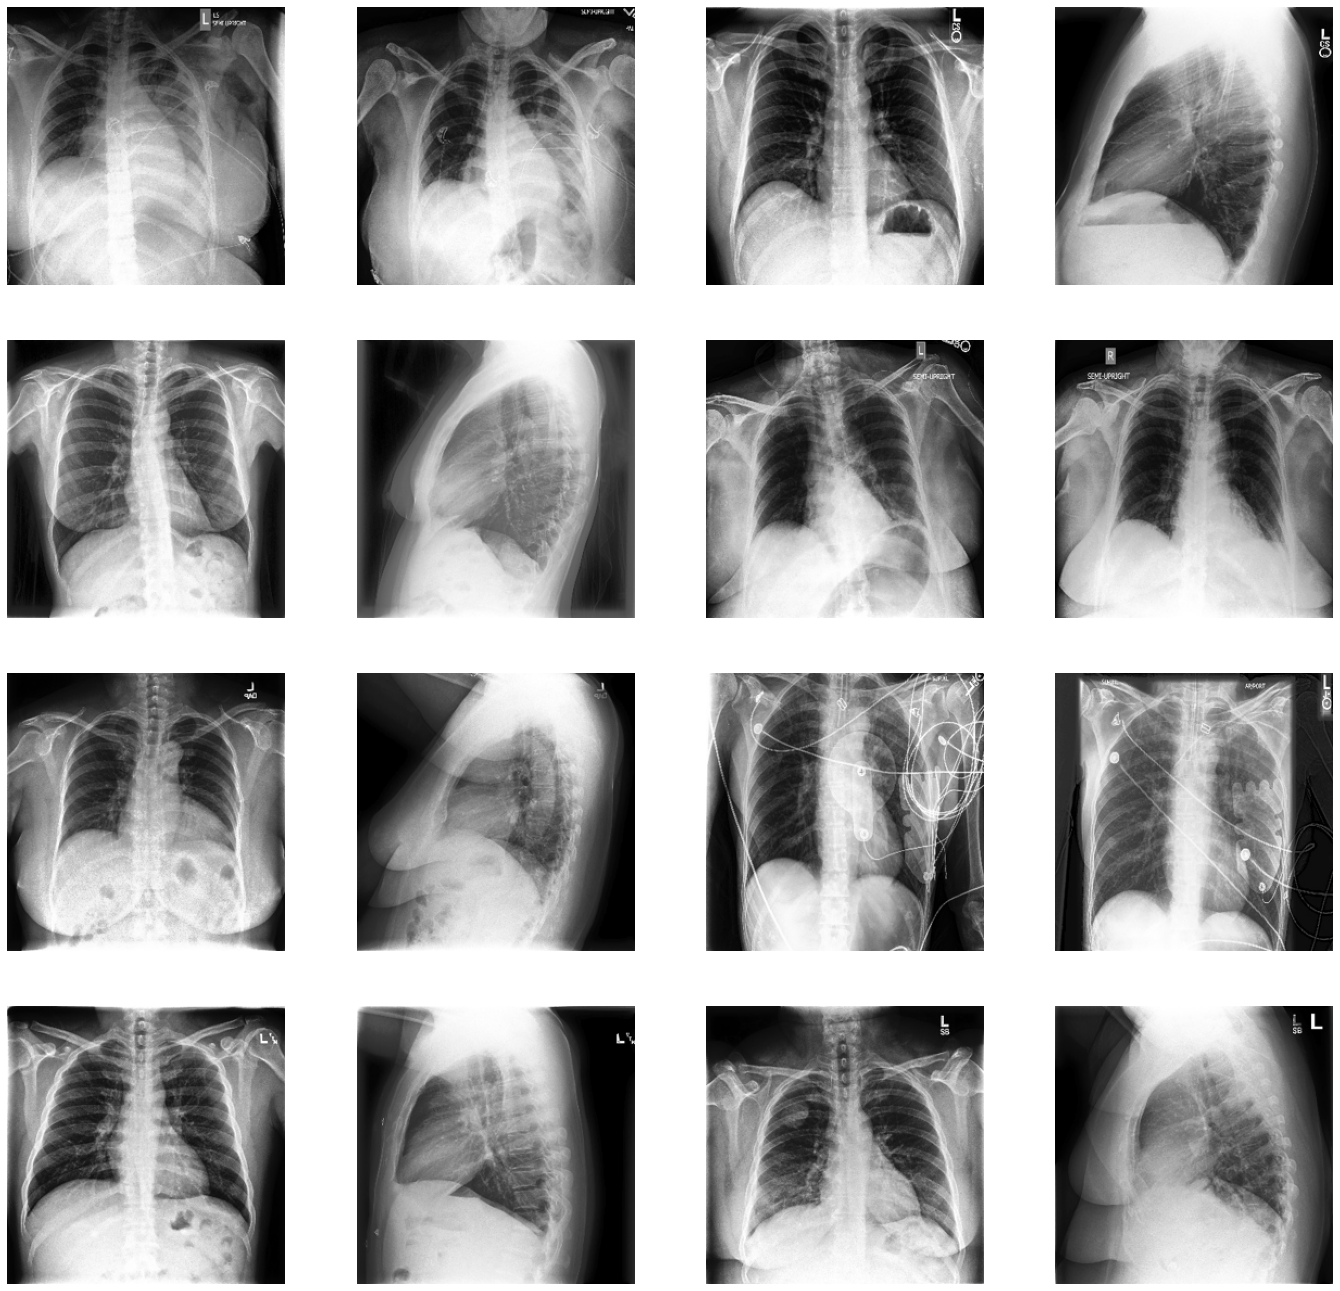

In [50]:
#unsharp_mask', 'gaussian_filter', 'windowing', 'median_filter', 'hist_equalization'
#benchmark.valgen.transformations = {}#{"hist_equalization":{}, "gaussian_blur":{"kernal_size":3}}
#benchmark.valgen.transformations = { "hist_equalization":{}, "gaussian_blur":{"kernal_size":3}}
plot_batch(benchmark.traingen, 2)

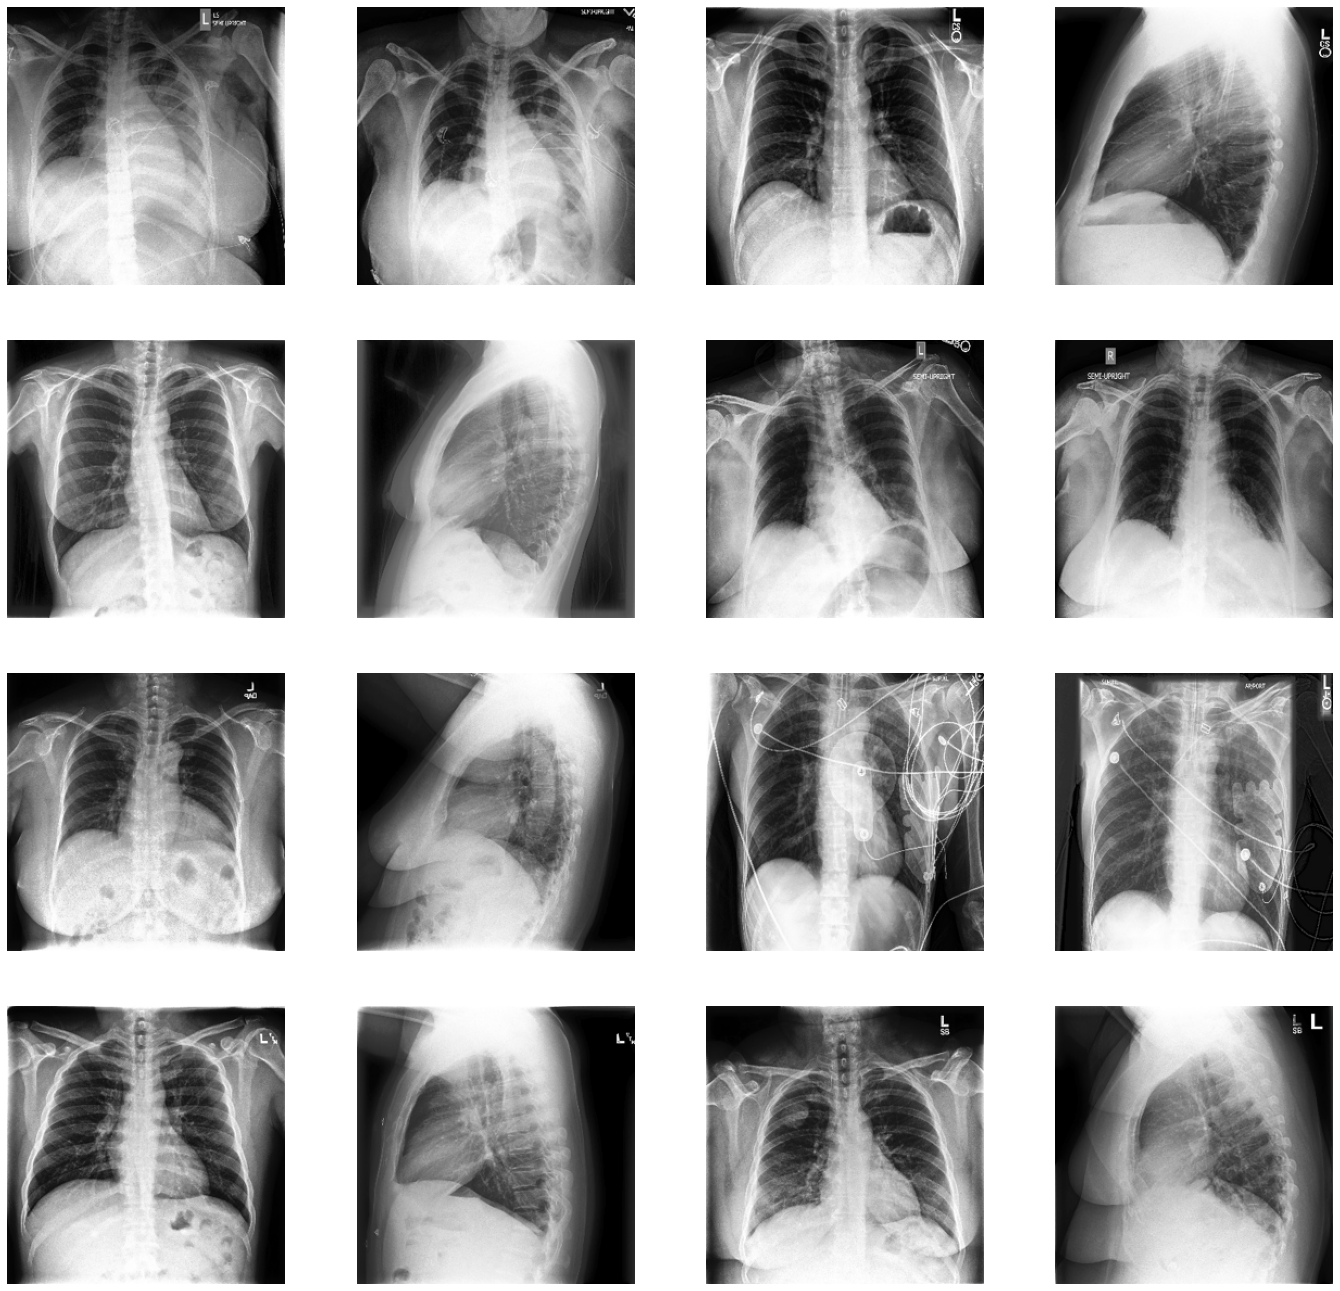

In [58]:
#unsharp_mask', 'gaussian_filter', 'windowing', 'median_filter', 'hist_equalization'
#benchmark.valgen.transformations = {}#{"hist_equalization":{}, "gaussian_blur":{"kernal_size":3}}
benchmark.traingen.transformations ={}
benchmark.traingen.augmentation=None
benchmark.traingen.crop=True
plot_batch(benchmark.traingen, 2)

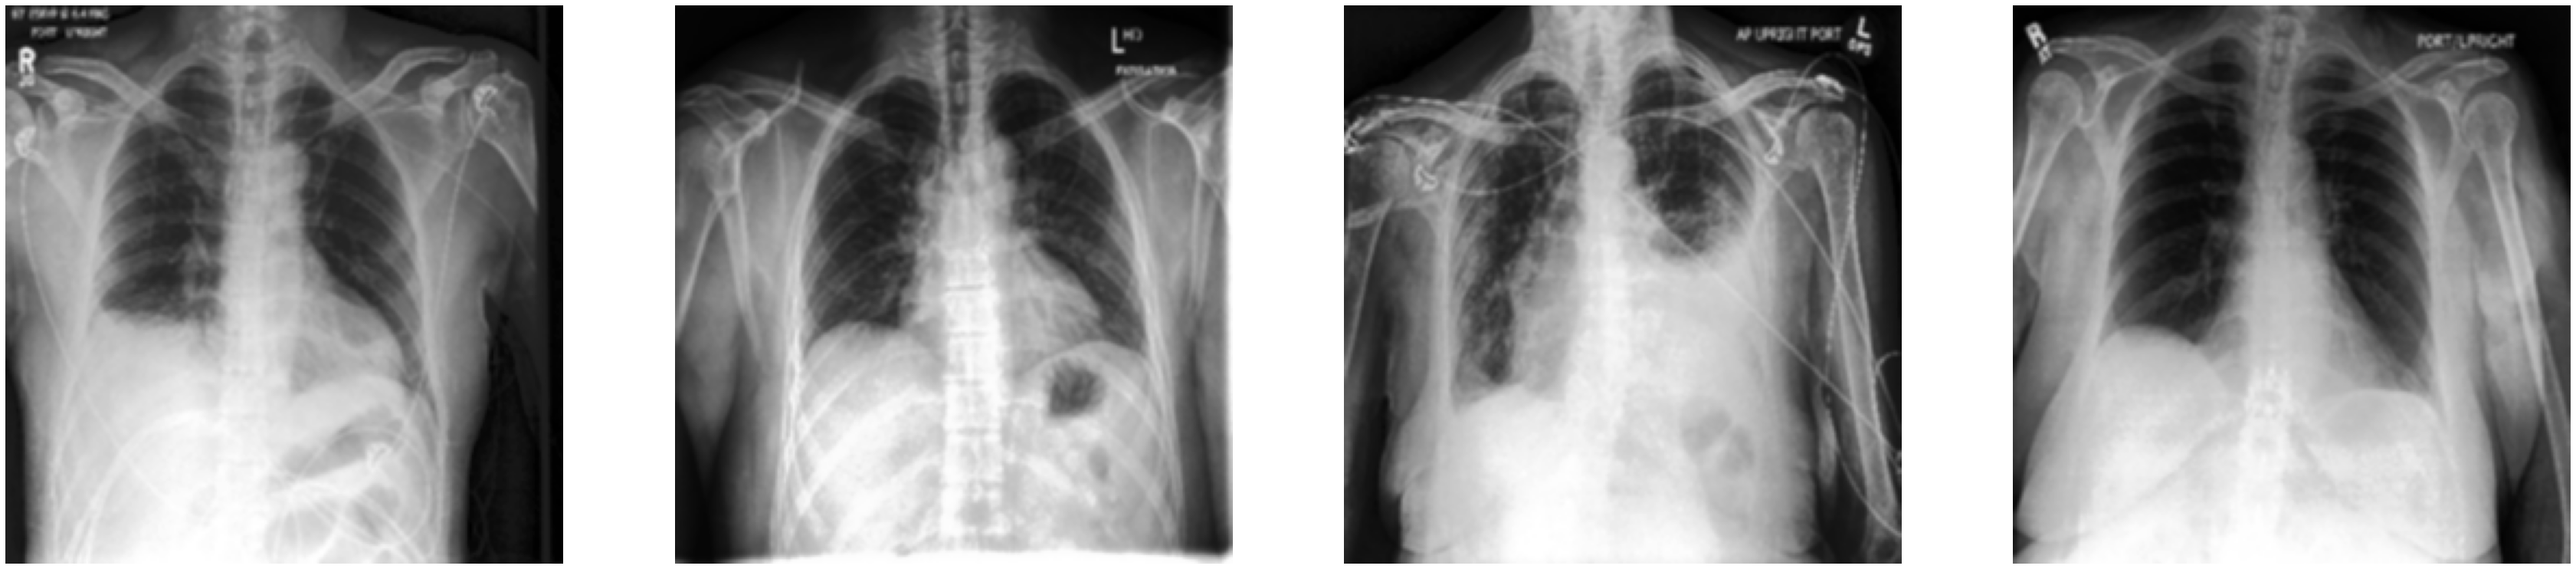

In [51]:
benchmark.valgen.transformations = {"unsharp_mask":{"radius":5, "amount":1}}
benchmark.valgen.transformations = { "gaussian_blur":{"kernal_size":3}, "hist_equalization":{}}
#benchmark.valgen.transformations = {"hist_equalization":{}}
plot_batch(benchmark.valgen, 5)

In [52]:
benchmark.testgen.batch_size

1

In [53]:
for index, value in enumerate(["No_Finding","Enlarged_Cardiomediastinum","Cardiomegaly","Lung_Opacity","Lung_Lesion","Edema","Consolidation","Pneumonia","Atelectasis","Pneumothorax","Pleural_Effusion","Pleural_Other","Fracture","Support_Devices"]):
    print(index, value)

0 No_Finding
1 Enlarged_Cardiomediastinum
2 Cardiomegaly
3 Lung_Opacity
4 Lung_Lesion
5 Edema
6 Consolidation
7 Pneumonia
8 Atelectasis
9 Pneumothorax
10 Pleural_Effusion
11 Pleural_Other
12 Fracture
13 Support_Devices
